# Processing NetCDFs in a RAM limted environment

## Review

What did we learn in the first two sections?

* Read rate is inversely proportional to slice fragmentation
* Reading from RAM is really, really fast (after paying the initial cost)
* The NetCDF library simplifies our code by a factor of 20
* The NetCDF library is reasonably fast

For this part of the tutorial, we want to find out what happens when we run out of memory and how to work around it. Normally you find this out by accident at the end of a long processing chain that takes minutes or hours to run. We really don't want to wait that long so let's boil this down. How can we run out of memory with our small-ish 1GB array?

## Constraining Memory

It turns out that Linux has a number of system calls that allow anyone, root or otherwise, to set resource limits on processes. As a regular user, we are allowed to limit the resources of our own processes at will. And Python gives us bindings to those system calls through the `resource` module.

Without getting too deep into operating system internals, it's challenging to understand all of the various ways to measure RAM usage. OSes use a hiearchichal address space that gets consumed by and shared between many different processes and many different pieces of a program. You can read a bit more about some options in [the exteded version of the RAM limiting tutorial](), but for now just trust me that this:

    with mem_limiter(50 * 1024 ** 2):
        print("Running some code")

will raise a MemoryError if we exceed 50MB of data before or after the block.

In [1]:
# Start with a few standard imports
import numpy as np
import os

In [2]:
# %load ../src/utils.py
import os
import math
from time import time
import resource
from collections import namedtuple
from contextlib import contextmanager, ContextDecorator
from tempfile import NamedTemporaryFile

import netCDF4
import numpy as np

def make_netcdf3_file(shape, variable_name='some_variable', dir_=os.getcwd()):

    with NamedTemporaryFile(suffix='.nc', dir=dir_, delete=False) as f:

        nc = netCDF4.Dataset(f.name, 'w', format='NETCDF3_CLASSIC')
        nc.createDimension('x', shape[2])
        nc.createDimension('y', shape[1])
        nc.createDimension('z', shape[0])
        some_var = nc.createVariable('some_variable','f4',('z', 'y', 'x'))

    def trip(x, y, z):
        d = math.sqrt((x - 256) ** 2 + (y - 256) ** 2)
        return math.sin(d / 64) + math.sin(z)
    trip_v = np.vectorize(trip)

    x, y = np.meshgrid(range(shape[2]), range(shape[1]))
    basegrid = trip_v(x, y, 0).astype('float32')

    for z in range(shape[0]):
        a = basegrid + math.sin(z / 32)
        some_var[z,:,:] = a

    nc.close()

    return f.name

MemUsage = namedtuple('MemUsage', 'size resident share text lib data dt')

def get_mem_usage():
    pid = os.getpid()
    with open('/proc/{}/statm'.format(pid)) as f:
        string = f.read()
    return MemUsage._make([int(x) for x in string.split()])    
    
@contextmanager
def mem_limiter(bytes_):
    if get_mem_usage().data > bytes_:
        raise MemoryError("You're already using {} bytes which is over the limit of {} bytes".format(get_mem_usage().data, bytes_))
    yield
    if get_mem_usage().data > bytes_:
        raise MemoryError("FAIL! You're using {} bytes which is over the limit of {} bytes".format(get_mem_usage().data, bytes_))

class ThroughputMeter(ContextDecorator):
    def __enter__(self):
        self.t0 = time()
        return self
    def __exit__(self, *exc):
        self.tn = time()

    def megabytes_per_second(self, array):
        seconds = self.tn - self.t0
        MB = np.prod(array.shape) / 1024 ** 2 * array.dtype.itemsize
        MBps = MB / seconds
        print("{:03.3f} MB in {:03.3} seconds at {:03.3f} MB / sec".format(MB, seconds, MBps))
        return MBps


We'll start by creating a half GB NetCDF file, and then assume that we need to compute some statistics on it with limited memory.

In [3]:
filename = make_netcdf3_file((256, 1024, 1024))

In [4]:
filename

'/home/james/code/git/netcdf-tutorial/notebooks/tmpzmn2i3.nc'

In [5]:
get_mem_usage().data

111816

## Iteration

Let's pretend that we need to compute the mean value across space at each time step. Since we don't have enough RAM for the full timeseries, we need to *iterate* over it, only loading one timestep at a time.

In [6]:
def simple_iteration():
    nc = netCDF4.Dataset(filename)
    some_var = nc.variables['some_variable']
    tn, yn, xn = some_var.shape
    the_means = np.empty((tn,))
    for t in range(tn):
        with mem_limiter(50 * 1024 ** 2):
            the_means[t] = np.mean(some_var[t,:,:])
    nc.close()
    return the_means

In [7]:
%%timeit
simple_iteration()

1 loops, best of 3: 962 ms per loop


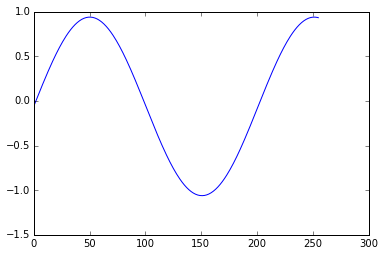

In [8]:
from matplotlib import pyplot
%matplotlib inline

pyplot.plot(simple_iteration())

In [9]:
get_mem_usage().data

113546

The code and the looping for this was extremely straightforward and intuitive. One loop, with one operation per loop. If you can get your work done in this manner, please go for it!

## Utilization

One property that it *doesn't* exhibit, howerver, is high utilization of the memory that we *do* have available.

In [10]:
nc = netCDF4.Dataset(filename)
len(nc.dimensions['x']) * len(nc.dimensions['y']) * np.dtype('float64').itemsize

8388608

We have about 50 MB available, but we're only utilizing a little more than 8 MB per loop. Recall that we get better performance, with the fewer reads that we do. So it's to our advantage to fill up as much RAM as we can and work from there. This is usually described as *chunking*. *Not* to be confused with NetCDF4 chunking, which is similar, but different. We'll get to that.

What would our loop look like with a high utilization chunking strategy? We have to do a few extra things:

* Compute an optimal chunk size, one that fills available memory
* Read in some number of time steps
* Peform our computation *on* the space axes (along the time axis)

The code to do so looks like this:

In [11]:
def chunked_iteration():
    
    my_limit = 50 * 1024 ** 2

    def compute_chunk_size(limit, slice_size):
        return int(limit // slice_size)

    nc = netCDF4.Dataset(filename)
    some_var = nc.variables['some_variable']
    tn, yn, xn = some_var.shape
    the_means = np.empty((tn,))
    
    chunk_size = compute_chunk_size(my_limit, yn * xn * np.dtype('float64').itemsize)
    for t in range(0, tn, chunk_size):
        with mem_limiter(my_limit):
            a = some_var[t:t+chunk_size,:,:]
            the_means[t:t+chunk_size] = np.mean(a, axis=(1, 2))
    nc.close()
    return the_means


In [12]:
%%timeit
the_means = chunked_iteration()

1 loops, best of 3: 882 ms per loop


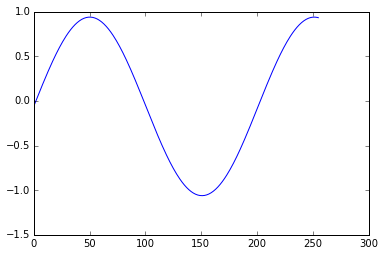

In [13]:
pyplot.plot(chunked_iteration())

In [15]:
.962 / .882

1.090702947845805

So you can see that the code runs a *little* bit faster, at the expense of having some slightly more complex code. It took us 16 lines to write what we previously wrote in 8. 8 lines of code may not seem like a lot, but put another way: we had to write twice as much code. It's harder to read and understand, harder to maintain, and easier to make mistakes.

But... it *is* a little faster, and this may make a difference if you're running hundreds of simulations, or processing terabytes of data. It's up to you to decide whether the trade off is worth it.